In [2]:
import pandas as pd
import numpy as np
# from scipy.stats import pearsonr, median_abs_deviation
# from sklearn import metrics
import sys
import os
from statsmodels.stats.multitest import multipletests
from scipy.stats import combine_pvalues, norm, mannwhitneyu, spearmanr, pearsonr
from read_clustering.variant_call import VariantCalls
import matplotlib.pyplot as plt
from scipy.stats import shapiro, combine_pvalues
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import combine_pvalues, norm, mannwhitneyu
from scipy.stats import chi2_contingency


/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# final ivt vs native
CBF5GAL = "modification_calls/20190610_R941_CBF5GAL.csv"
CBF5GLU = "modification_calls/20190611_R941_CBF5GLU.csv"
NOP58GAL = "modification_calls/20190617_R941_NOP58GAL.csv"
NOP58GLU = "modification_calls/20190619_R941_NOP58GLU.csv"
IVT = "modification_calls/20191014_R941_IVT.csv"
mutant448 = "modification_calls/20210405_R941_mutant448.csv"
WT_YPD = "modification_calls/20210410_R941_WT_YPD.csv"
WT_KOAC = "modification_calls/20210412_R941_WT_KOAC.csv"
mutant452 = "modification_calls/20210413_R941_mutant452.csv"
WT_CY = "modification_calls/20210414_R941_WT_CY.csv"
mutant451 = "modification_calls/20210415_R941_mutant451.csv"
WT_PB = "modification_calls/20210520_R941_WT_PB.csv"
WT_stationary = "modification_calls/20210521_R941_WT_stationary.csv"
Dbp3d_YPD = "modification_calls/20210527_R941_Dbp3d_YPD.csv"
trl1d_YPD = "modification_calls/20210528_R941_trl1d_YPD.csv"
WT_rapa5 = "modification_calls/20210531_R941_WT_rapa5.csv"
Mix = "modification_calls/20210618_R941_Mix.csv"
prp43 = "modification_calls/20210619_R941_prp43.csv"
MIX_2 = "modification_calls/20210716_R941_MIX.csv"
YS602_18_YPD = "modification_calls/20210717_R941_YS602_18_YPD.csv"
prp16_18deg_YPD = "modification_calls/20210719_R941_prp16_18deg_YPD.csv"
spp382_YPD = "modification_calls/20210720_R941_spp382_YPD.csv"
YS602_18_YPD2 = "modification_calls/20210722_R941_YS602_18_YPD2.csv"
dbr1d_YPD = "modification_calls/20210729_R941_dbr1d_YPD.csv"
sqs1d_YPD = "modification_calls/20210730_R941_sqs1d_YPD.csv"
snR4d_YPD = "modification_calls/20210823_R941_snR4d_YPD.csv"
snR45d_YPD = "modification_calls/20210824_R941_snR45d_YPD.csv"
mutant448_2 = "modification_calls/20210825_R941_mutant448.csv"
snR4d_alpha_YPD = "modification_calls/20210902_R941_snR4d_alpha_YPD.csv"
WT_YPD2 = "modification_calls/20210930_R941_YS602_WT_repeat2.csv"
WT_YPD3 = "modification_calls/20211001_R941_YS602_WT_repeat3.csv"
prx1 = "modification_calls/20211006_R941_pxr1d_YPD.csv"
YS602_18_YPD3 = "modification_calls/20211007_R941_YS602_18_YPD3.csv"
prp43_2 = "modification_calls/20211008_R941_prp43_18deg_YPD_repeat2.csv"
Dbp3d_YPD2 = "modification_calls/20211011_R941_dbp3d_YPD_repeat2.csv"
prx1_2 = "modification_calls/20211021_pxr1d_YPD_repeat2.csv"


In [4]:
corrected_pvalues_df = pd.read_csv("figures/summary_data/all_experiment_percent_modification_corrected_pvalues_chi2.csv", 
                                   index_col=0)


In [5]:
def get_precent_mod_group(labels, contig, corrected_pvalues_df, width, pvalue_cutoff, max_diff, method="min"):
    wt_labels = ["WT_YPD", "WT_YPD2", "WT_YPD3"]  
    options = ("min", "average")
    assert method in options, f"Method must be in {options}"
    if not isinstance(labels, list):
        labels = [labels]
    ###
    all_diffs = []
    all_pvalues = []
    for label in labels:
        for wt_l in wt_labels:
            diff = corrected_pvalues_df[f"{label}_mean"] - corrected_pvalues_df[wt_l+"_mean"]
            all_diffs.append(diff)
            pvalue_mask = (corrected_pvalues_df[f"{label}_corrected_pvalue"] < pvalue_cutoff)   
            all_pvalues.append(pvalue_mask)
            
    all_diffs_df = pd.DataFrame(all_diffs)
    per_position_index = np.abs(pd.DataFrame(all_diffs)).idxmin()
    y_all = pd.Series(all_diffs_df.lookup(per_position_index.values, per_position_index.index), index=per_position_index.index)
    pvalue_mask = pd.DataFrame(all_pvalues).all()

    return y_all, pvalue_mask


In [6]:
def plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path):
    wt_labels = ["WT_YPD", "WT_YPD2", "WT_YPD3"]  
    all_diffs = []
    for i, wt_l in enumerate(wt_labels):
        for wt_2 in wt_labels[i+1:]:
            diff = corrected_pvalues_df[wt_l+"_mean"] - corrected_pvalues_df[wt_2+"_mean"]
            all_diffs.append(diff)
    all_df = pd.DataFrame(all_diffs)
    per_position_max_diff = np.abs(all_df).max()
    max_diff = per_position_max_diff.max() + 0.01
    title = contig
    pvalue_cutoff = 0.05
    fig, axs = plt.subplots(1, figsize=(30,10))
    axs.set_title(title, fontdict={'fontsize':20})
    width = 0.8 / len(all_labels)
#     width = 1.5 / len(all_labels)

    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
#     colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c"]
    colors = ["black", "#A95AA1", "#F5793A", "#85C0F9", "#0F2080"]
#     colors = ["black", '#004488', '#DDAA33', '#BB5566']
    colors = ['#4477AA', '#EE6677', '#CCBB44', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
    colors = ['#4477AA', '#EE6677', '#CCBB44', '#228833', '#66CCEE', '#AA3377', '#BBBBBB'][::-1]

    hatch_types = ["-", '+', 'x', 'o', 'O', '.', '*', "/", "\\", "|"]
    mask = (corrected_pvalues_df["contig"] == contig).values
    
    if len(all_labels) % 2 == 0:
        scale = [0.5, 0.5, 1.5, 1.5, 2.5, 2.5]
    else:
        scale = [0, 1, 1, 2, 2, 3, 3]
    for i, label in enumerate(all_labels):
        y_all, pvalue_mask = get_precent_mod_group(label, contig, corrected_pvalues_df, width, pvalue_cutoff, max_diff, method="min")

        x = y_all[mask].index
        y = y_all[mask]
        

        if i % 2 == 0:
            x1 = np.array(range(len(x)))+(scale[i]*width)
        else:
            x1 = np.array(range(len(x)))-(scale[i]*width)
        
        axs.bar(x1, y, width, label=label, 
#                 hatch=hatch_types[i], 
                color=colors[i], 
                linewidth=0.5,
#                 align="edge",
                edgecolor="black")
#         axs.scatter(x1[pvalue_mask[mask]], y[pvalue_mask&mask] + (np.sign(y[pvalue_mask&mask]) * 0.015), marker="*", color="black", zorder=10, s=250)
        axs.set_xticks(ticks=[x for x in range(len(x))], minor=True)
        axs.set_xticks(ticks=[x-0.5 for x in range(len(x)+1)], minor=False)
        axs.set_yticks(ticks=np.linspace(-1, 1, num=21, endpoint=True))
        axs.set_xticklabels(labels=x, minor=True)
        axs.set_xticklabels(labels=["" for x in x], minor=False)

    #     axs.grid(True, which='minor', axis='x')
        axs.grid(True, which='major')

    axs.set_ylim(-1, 0.15)
    axs.axhline(y=max_diff, ls="--", color="black")
    axs.axhline(y=-max_diff,ls="--", color="black")
    x1 = np.array(range(len(x)))
    axs.bar(x1, per_position_max_diff[mask], 1, label="Max WT DIFF", color="black", alpha=0.35)
    axs.bar(x1, -per_position_max_diff[mask], 1, label="Max WT DIFF", color="black", alpha=0.35)
    plt.legend()

    if figure_path is not None:
        plt.savefig(figure_path)
    else:
        plt.show()

In [7]:
def plot_percent_mod2(all_labels, contig, corrected_pvalues_df, figure_path, 
                      colors=['#4477AA', '#EE6677', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']):
    wt_labels = ["WT_YPD", "WT_YPD2", "WT_YPD3"]  
    all_diffs = []
    for i, wt_l in enumerate(wt_labels):
        for wt_2 in wt_labels[i+1:]:
            diff = corrected_pvalues_df[wt_l+"_mean"] - corrected_pvalues_df[wt_2+"_mean"]
            all_diffs.append(diff)
    all_df = pd.DataFrame(all_diffs)
    per_position_max_diff = np.abs(all_df).max()
    max_diff = per_position_max_diff.max() + 0.01
    print(max_diff)
    title = contig
    pvalue_cutoff = 0.05
    linewidth = 0.5
    fig, axs = plt.subplots(1, figsize=(30,10))
    axs.set_title(title, fontdict={'fontsize':20})
    gap = 0.1
    width = 0.8 - (gap*len(all_labels))
    if len(all_labels) % 2 == 0:
        shift = [+(0.5*gap), -(0.5*gap), +(1.5*gap), -(1.5*gap), +(2.5*gap), -(2.5*gap)]
    else:
        shift = [0, +gap, -gap, +(2*gap), -(2*gap), +(3*gap), -(3*gap)]

#     width = 1.5 / len(all_labels)

#     colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# #     colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c"]
#     colors = ["black", "#A95AA1", "#F5793A", "#85C0F9", "#0F2080"]
# #     colors = ["black", '#004488', '#DDAA33', '#BB5566']
#     colors = ['#4477AA', '#EE6677', '#AA3377', '#228833', '#66CCEE', '#CCBB44']
#     colors = ['#4477AA', '#EE6677', '#CCBB44', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
#     colors = ['#4477AA', '#EE6677', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
#     colors = sns.color_palette("colorblind")

#     https://personal.sron.nl/~pault/
    # https://davidmathlogic.com/colorblind/
#     https://www.color-blindness.com/coblis-color-blindness-simulator/
    hatch_types = ["-", '+', 'x', 'o', 'O', '.', '*', "/", "\\", "|"]
    mask = (corrected_pvalues_df["contig"] == contig).values
    
    if len(all_labels) % 2 == 0:
        scale = [0.5, 0.5, 1.5, 1.5, 2.5, 2.5]
    else:
        scale = [0, 1, 1, 2, 2, 3, 3]
    
    patches = []
    all_labels_y = [] 
    for i, label in enumerate(all_labels):
        y_all, pvalue_mask = get_precent_mod_group(label, contig, corrected_pvalues_df, width, pvalue_cutoff, max_diff, method="min")

        y = y_all[mask]
        x = y_all[mask].index

        if i % 2 == 0:
            x1 = np.array(range(len(x)))+(scale[i]*width)
        else:
            x1 = np.array(range(len(x)))-(scale[i]*width)
        all_labels_y.append(y)
        patches.append(mpatches.Patch(facecolor=colors[i], label=label))

    for i, (_, y) in enumerate(pd.DataFrame(all_labels_y).iteritems()):
        positive = []
        for c, y1 in y.sort_values().iteritems():
            if y1 > 0:
                positive.append((c, y1))
            else:
                axs.bar(i+shift[c], y1, width, 
            #                 hatch=hatch_types[i], 
                        color=colors[c], 
                        linewidth=linewidth,
            #                 align="edge",
                        edgecolor="black")
        for c, y1 in positive[::-1]:
            axs.bar(i+shift[c], y1, width, 
        #                 hatch=hatch_types[i], 
                    color=colors[c], 
                    linewidth=linewidth,
        #                 align="edge",
                    edgecolor="black")

#         axs.scatter(x1[pvalue_mask[mask]], y[pvalue_mask&mask] + (np.sign(y[pvalue_mask&mask]) * 0.015), marker="*", color="black", zorder=10, s=250)
    
    axs.set_xticks(ticks=[x for x in range(len(x))], minor=True)
    axs.set_xticks(ticks=[x-0.5 for x in range(len(x)+1)], minor=False)
    axs.set_yticks(ticks=np.linspace(-1, 1, num=21, endpoint=True))
    axs.set_xticklabels(labels=x, minor=True)
    axs.set_xticklabels(labels=["" for x in x], minor=False)
    axs.grid(True, which='major')
    axs.set_ylim(-1, 0.15)
    axs.axhline(y=max_diff, ls="--", color="black")
    axs.axhline(y=-max_diff,ls="--", color="black")
    x1 = np.array(range(len(x)))
    axs.bar(x1, per_position_max_diff[mask], 1, label="Max WT DIFF", color="black", alpha=0.35)
    axs.bar(x1, -per_position_max_diff[mask], 1, label="Max WT DIFF", color="black", alpha=0.35)
    patches.append(mpatches.Patch(facecolor="black", alpha=0.35, label="Max WT DIFF"))

#     plt.legend(handles=patches)

    if figure_path is not None:
        plt.savefig(figure_path)
    else:
        plt.show()
        
    return all_labels_y

0.1036665989297567
0.1036665989297567


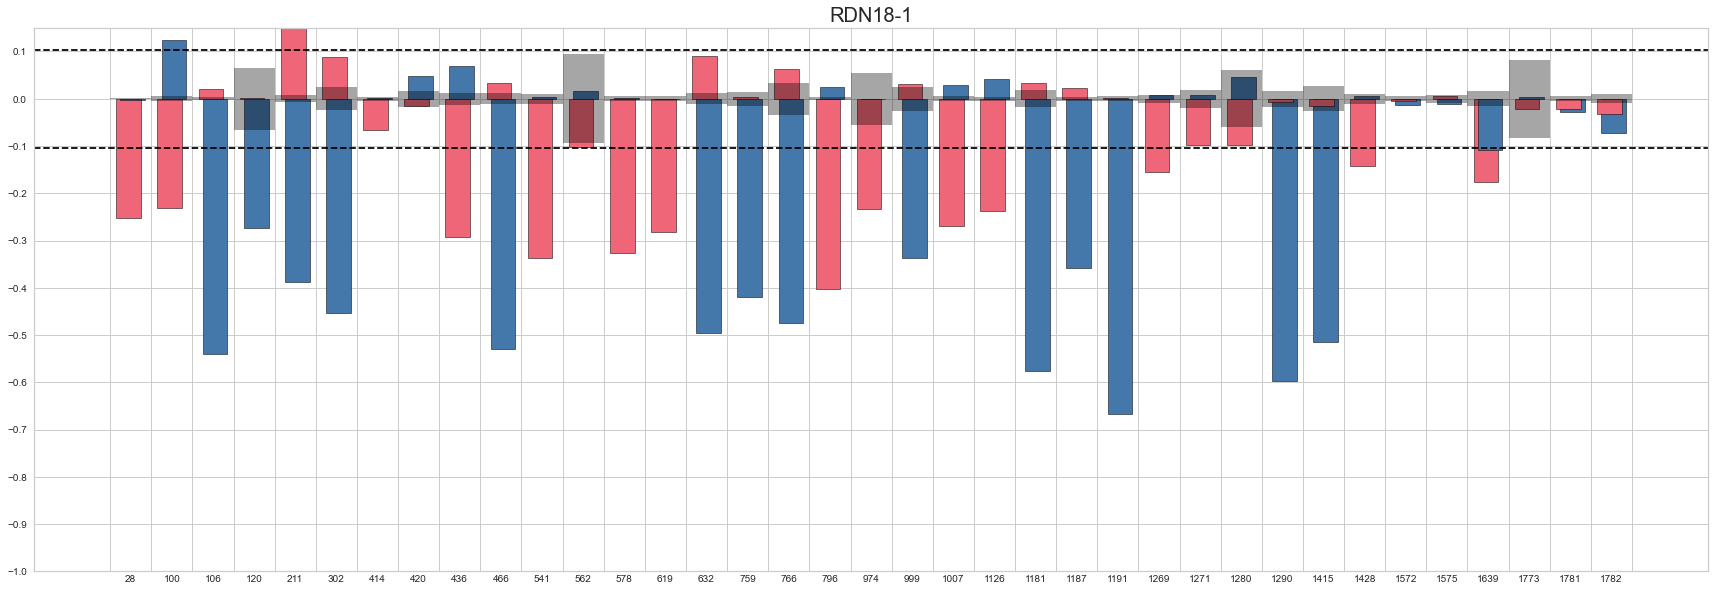

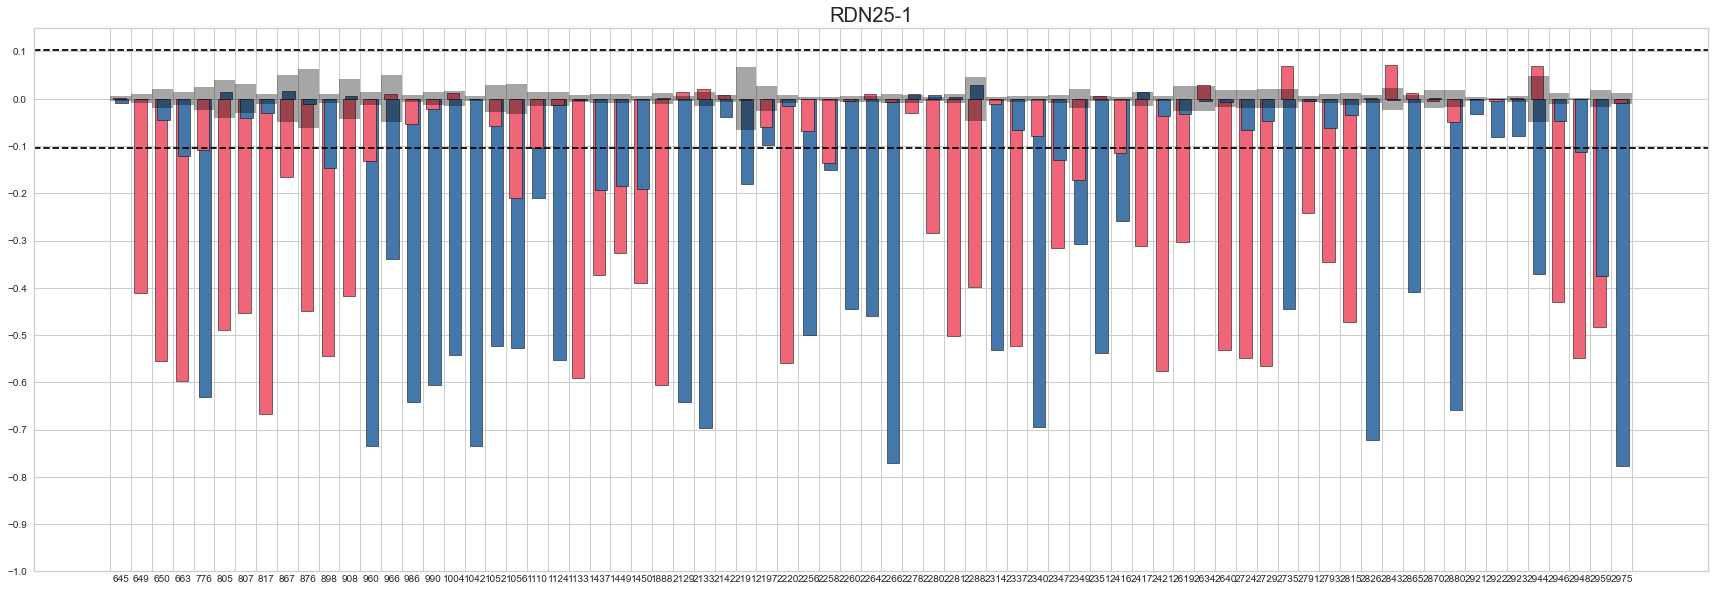

In [9]:
for contig in ["RDN18-1", "RDN25-1"]:
#     figure_path = f"figures/dbp3_prp43/{contig}_helicase_bargraph_no_legend.png"
#     all_labels = [["prx1", "prx1_2"], ["prp43", "prp43_2"], ["Dbp3d_YPD", "Dbp3d_YPD2"], "sqs1d_YPD"]
#     all_y = plot_percent_mod2(all_labels, contig, corrected_pvalues_df, figure_path)

#     figure_path = f"figures/sno_rna_knockouts/{contig}_snornaKO_bargraph_no_legend.png"
#     all_labels = ["snR4d_alpha_YPD", "mutant452", "mutant451", "mutant448_2", "snR45d_YPD", ["MIX_2", "Mix"]] 
# # all_labels = ["9WT_YPD", "1snR4d_alpha_YPD", "2mutant452", "3mutant451", "4mutant448", "5snR45d_YPD", "6MIX_2"] 
# # color_map = ['#4477AA', '#EE6677', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB', "#228833"]

#     colors = ["#228833", '#EE6677', '#4477AA', '#66CCEE', '#BBBBBB', '#AA3377','#CCBB44']
#     plot_percent_mod2(all_labels, contig, corrected_pvalues_df, figure_path, colors=colors)

#     figure_path = f"figures/splicing_mutants/{contig}_splicing_mutations_bargraph.png"
#     all_labels = ["dbr1d_YPD", "spp382_YPD", "prp16_18deg_YPD"] 
#     plot_percent_mod2(all_labels, contig, corrected_pvalues_df, figure_path)

#     all_labels = ["WT_KOAC", "WT_CY", "WT_stationary", "WT_rapa5", ["YS602_18_YPD", "YS602_18_YPD2", "YS602_18_YPD3"]]  
#     figure_path = f"figures/wt_ivt_environment_conditions/{contig}_conditions_bargraph.png"
#     plot_percent_mod2(all_labels, contig, corrected_pvalues_df, figure_path)

    figure_path = f"/Users/andrewbailey/Desktop/{contig}_bargraph.png"
    all_labels = ["CBF5GLU", "NOP58GLU"]
#     
# all_labels = [spp382_YPD"] 
    plot_percent_mod2(all_labels, contig, corrected_pvalues_df, figure_path, colors=['#4477AA', '#EE6677', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])



In [20]:
corrected_pvalues_df["dbr1d_YPD_mean"][974] - corrected_pvalues_df["WT_YPD2_mean"][974] 

-0.10977929941163556

In [23]:
corrected_pvalues_df["dbr1d_YPD_corrected_pvalue"][974]

1.7802272435515587e-28